In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Dataset from UCI Machine Learning Repository : Churn Dataset,
Goal is to build a deep learning model to predict churn variable

In [3]:
df = pd.read_csv('churn.txt')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   State           3333 non-null   object 
 1   Account Length  3333 non-null   int64  
 2   Area Code       3333 non-null   int64  
 3   Phone           3333 non-null   object 
 4   Int'l Plan      3333 non-null   object 
 5   VMail Plan      3333 non-null   object 
 6   VMail Message   3333 non-null   int64  
 7   Day Mins        3333 non-null   float64
 8   Day Calls       3333 non-null   int64  
 9   Day Charge      3333 non-null   float64
 10  Eve Mins        3333 non-null   float64
 11  Eve Calls       3333 non-null   int64  
 12  Eve Charge      3333 non-null   float64
 13  Night Mins      3333 non-null   float64
 14  Night Calls     3333 non-null   int64  
 15  Night Charge    3333 non-null   float64
 16  Intl Mins       3333 non-null   float64
 17  Intl Calls      3333 non-null   i

In [4]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


Changing Area code to type string since it's not really a numeric type

In [5]:
df['Area Code'] = df['Area Code'].astype(str)

We can look more into what our object values are and if they are repeatable/measurable/regressable

In [6]:
df.select_dtypes(include=('object')).describe()

,State,Area Code,Phone,Int'l Plan,VMail Plan,Churn?
count,3333,3333,3333,3333,3333,3333
unique,51,3,3333,2,2,2
top,WV,415,382-4657,no,no,False.
freq,106,1655,1,3010,2411,2850


Since Phone has no repeats, it supplies no information that we can separate Churn True/False. If we supply it to our model, it would fit a weight of 0 (or asymptotically 0) to the Phone feature. Instead of wasting our fitting time we should drop it instead.

In [7]:
df.drop('Phone', axis=1, inplace=True)

Lets take a look why there are 51 states instead of 50

In [8]:
df['State'].unique()

array(['KS', 'OH', 'NJ', 'OK', 'AL', 'MA', 'MO', 'LA', 'WV', 'IN', 'RI',
       'IA', 'MT', 'NY', 'ID', 'VT', 'VA', 'TX', 'FL', 'CO', 'AZ', 'SC',
       'NE', 'WY', 'HI', 'IL', 'NH', 'GA', 'AK', 'MD', 'AR', 'WI', 'OR',
       'MI', 'DE', 'UT', 'CA', 'MN', 'SD', 'NC', 'WA', 'NM', 'NV', 'DC',
       'KY', 'ME', 'MS', 'TN', 'PA', 'CT', 'ND'], dtype=object)

Looks like DC is included as a State

## Cleaning the data
### By using two outlier detection algorithms, we can identify if any of the algorithms detect outliers that overlap and we can remove those to clean the data up.
Intuitively, the outcome is an extremely important feature and we would expect there to be two clusters - one around each label. So if we drop the outcome feature then we should expect to have more outliers since the observations are less likely to cluster cleanly. The remaining features in the dataset need to be strong enough to define the clusters.\
Making a function to run outlier detection

In [9]:
def run_outlier_detection(df_to_fit): 
    # n_jobs=-1 means to parallelize with all processors
    # nu=0.05 means we expect 5% to be outliers
    detectors = [IsolationForest(n_jobs=-1), OneClassSVM(nu=0.05), LocalOutlierFactor(n_jobs=-1), EllipticEnvelope()]
    prediction_outputs = []

    for d in detectors:
        predicted = d.fit_predict(df_to_fit)
        prediction_outputs.append(predicted)
        print(d.__class__.__name__)
        print(pd.crosstab(predicted, columns=['count']))
    
    return prediction_outputs

In [10]:
#encode categorical variables
categorical_features = df.select_dtypes(['object']).columns.values
df_encoded = pd.get_dummies(df, columns= categorical_features)
detection_results = run_outlier_detection(df_encoded)

IsolationForest
col_0  count
row_0       
1       3333
OneClassSVM
col_0  count
row_0       
-1       168
 1      3165
LocalOutlierFactor
col_0  count
row_0       
-1        15
 1      3318


C:\JupyterLab\resources\jlab_server\lib\site-packages\sklearn\covariance\_robust_covariance.py:738: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn(


EllipticEnvelope
col_0  count
row_0       
-1       334
 1      2999


EllipticEnvelope: Intuitively, this is probably a bad choice since the feature set is unlikely to be normally distributed and this is an assumption in that model. \

OneClassSVM: This model requires us to give it an expected outlier percentage to identify. We don't know how many outliers there are, so as a discovery technique, this is probably a poor choice as well.

For completeness, we will calculate the intersection of the three techniques that returned results. The SVM vs EE and LOF vs SVM+EE.

In [11]:
svm_outcome = np.where(detection_results[1] == -1)
lof_outcome = np.where(detection_results[2] == -1)
ee_outcome = np.where(detection_results[3] == -1)

train_mean = df.mean()
train_mean.name = "mean"

train_std = df.std()
train_std.name = "std"

svm_ee_intersection = np.intersect1d(svm_outcome, ee_outcome)
print("SVM vs EE")
print(f"Size of intersection: {len(svm_ee_intersection)}")

SVM vs EE
Size of intersection: 29


C:\Users\ADRIAN~2\AppData\Local\Temp/ipykernel_16256/2812121323.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_mean = df.mean()
C:\Users\ADRIAN~2\AppData\Local\Temp/ipykernel_16256/2812121323.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  train_std = df.std()


In [12]:
#lets look at different intersections
lof_ee_intersection = np.intersect1d(lof_outcome, ee_outcome)
print("LOF vs EE")
print(f"Size of intersection: {len(lof_ee_intersection)}")
lof_svm_intersection = np.intersect1d(lof_outcome, svm_outcome)
print("LOF vs SVM")
print(f"Size of intersection: {len(lof_svm_intersection)}")

LOF vs EE
Size of intersection: 5
LOF vs SVM
Size of intersection: 13


Since it seems that there was poor agreement between EE and SVM, as well as IsolationForest not finding any, we should be cautious about removing outliers.\
We will drop the ones from Local outlier factor since it has the fewest


In [13]:
print(f"Size before dropping outlier(s): {len(df_encoded)}")
df_processed = df_encoded.drop(lof_outcome[0])
df_processed.reset_index(drop=True, inplace=True)
print(f"Size after dropping outlier(s): {len(df_processed)}")

Size before dropping outlier(s): 3333
Size after dropping outlier(s): 3318


## Transforming / Preprocessing
Our goal is to scale the numerical columns and one hot encode the categorical columns.\
Using minmax scaler + pandas get dummies

In [14]:
numerical_features = df_processed.select_dtypes(['int64', 'float64']).columns.values
numerical_transform = MinMaxScaler()
numerical_processed = numerical_transform.fit_transform(df_processed[numerical_features])
df_clean = df_processed
df_clean.update(pd.DataFrame(numerical_processed, columns = numerical_features))
df_clean.head()

,Account Length,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,...,State_WY,Area Code_408,Area Code_415,Area Code_510,Int'l Plan_no,Int'l Plan_yes,VMail Plan_no,VMail Plan_yes,Churn?_False.,Churn?_True.
0,0.524793,0.490196,0.750146,0.592593,0.750129,0.482737,0.477273,0.482796,0.625176,0.395683,...,0,0,1,0,1,0,0,1,1,0
1,0.438017,0.509804,0.448397,0.688889,0.448294,0.476827,0.507576,0.476940,0.652554,0.482014,...,0,0,1,0,1,0,0,1,1,0
2,0.561983,0.000000,0.686880,0.622222,0.686846,0.245723,0.560606,0.245608,0.393452,0.489209,...,0,0,1,0,1,0,1,0,1,0
3,0.342975,0.000000,0.850146,0.303704,0.850111,0.061275,0.393939,0.061127,0.490262,0.381295,...,0,1,0,0,0,1,1,0,1,0
4,0.305785,0.000000,0.463265,0.614815,0.463214,0.330016,0.651515,0.330161,0.462038,0.611511,...,0,0,1,0,0,1,1,0,1,0


## Exploring Correlation 
Now we will look into how the variables are correlated to one another.\
Given that correlated features don't improve models, deal with the highly correlated variables by removing correlated features i.e., if you have two features that are highly correlated, you need to remove one.\
The reason for removing correlated features is to make the algorithm faster because less features means higher speed. Furthermore, removing highly correlated features decreases harmful bias in the final model.

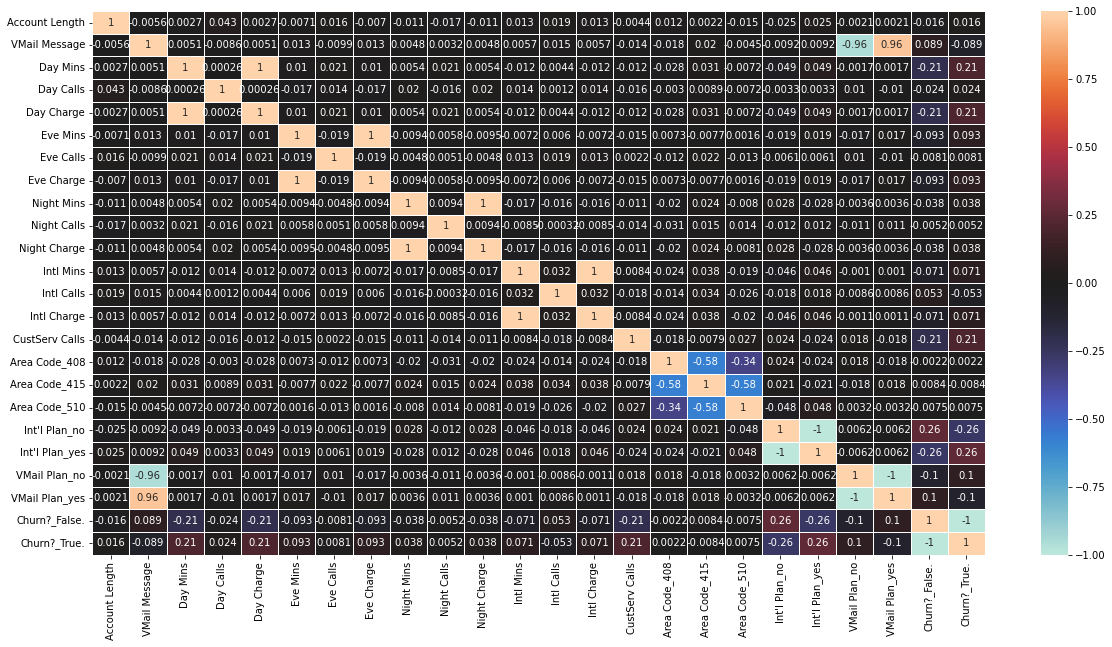

In [14]:
fig = sns.heatmap(df_clean.loc[:,df_clean.columns.str.contains('State')==False].corr(),annot=True,vmin=-1, vmax=1, center= 0, yticklabels=1, linewidths=.5)
fig.figure.set_size_inches(20,10)

There are clear instances of multicollinearity in this set:
- Day Charge ~ Day Mins
- Eve Charge ~ Eve Mins
- Night Charge ~ Night Mins
- Intl Charge ~ Intl Minutes
- VMail Message ~ VMail Plan
- All binary features have perfect correlation with their opposite value


- Charge ~ Mins: The customers are being charged at a rate of \\$/min.  When call time increases, charges go up by exactly \\$/min amount.
    - Drop the charge features.  The mins might be more interpretable since we don't really care about the rate.
- VMail: If someone doesn't pay for voicemail, then they won't have any voicemail messages.  Even if this isn't absolutely true (eg. 1 voicemail + voicemail plan), the correlation is close enough to 1 to justify removing the feature.
    - Strangely, Intl'l Plan doesn't correlate strongly with Intl Mins
    - Drop the VMail Plan feature.  This can always be determined from VMail Message.
- Binary features: If a value is true then it can't be false.
    - Drop the negative features since those are less intuitive.
    
We also find that most of the variables are uncorrelated with Churn.  I'll remove everything less than 0.01 (except VMail Message which is -0.009).  Two concerns with using uncorrelated data to predict an outcome are:
- Optimization - Removing unnecessary features will reduce the number of parameters in our model and will result in faster fitting times.
- Overfitting - It's possible that the model learns to use an "on average" uncorrelated feature to identify some specific samples in the training set.  However we know that on average, that feature does not correlate to the outcome class.  The specific learned behavior (and model weights) in this case won't generalize to an unseen test set.


In [15]:
df_clean.drop(['Day Charge','Eve Calls', 'Eve Charge','Night Calls', 'Night Charge', 'Intl Charge', "Int'l Plan_no", "VMail Plan_yes","VMail Plan_no", "Churn?_False.",
               'State_AK', 'State_AL', 'State_AR','State_AZ',
              'State_CA', 'State_CO', 'State_CT', 'State_DC', 'State_DE', 'State_FL',
       'State_GA', 'State_HI', 'State_IA', 'State_ID', 'State_IL', 'State_IN',
       'State_KS', 'State_KY', 'State_LA', 'State_MA', 'State_MD', 'State_ME',
       'State_MI', 'State_MN', 'State_MO', 'State_MS', 'State_MT', 'State_NC',
       'State_ND', 'State_NE', 'State_NH', 'State_NJ', 'State_NM', 'State_NV',
       'State_NY', 'State_OH', 'State_OK', 'State_OR', 'State_PA', 'State_RI',
       'State_SC', 'State_SD', 'State_TN', 'State_TX', 'State_UT', 'State_VA',
       'State_VT', 'State_WA', 'State_WI', 'State_WV', 'State_WY', 'Area Code_408', 'Area Code_415', 'Area Code_510'
               ], axis=1, inplace=True)
df_clean.rename(columns={"Int'l Plan_yes": "Intl Plan", "VMail Plan_yes": "VMail Plan", "Churn?_True.": "Churn"}, inplace=True)

Let's look again at the correlation matrix

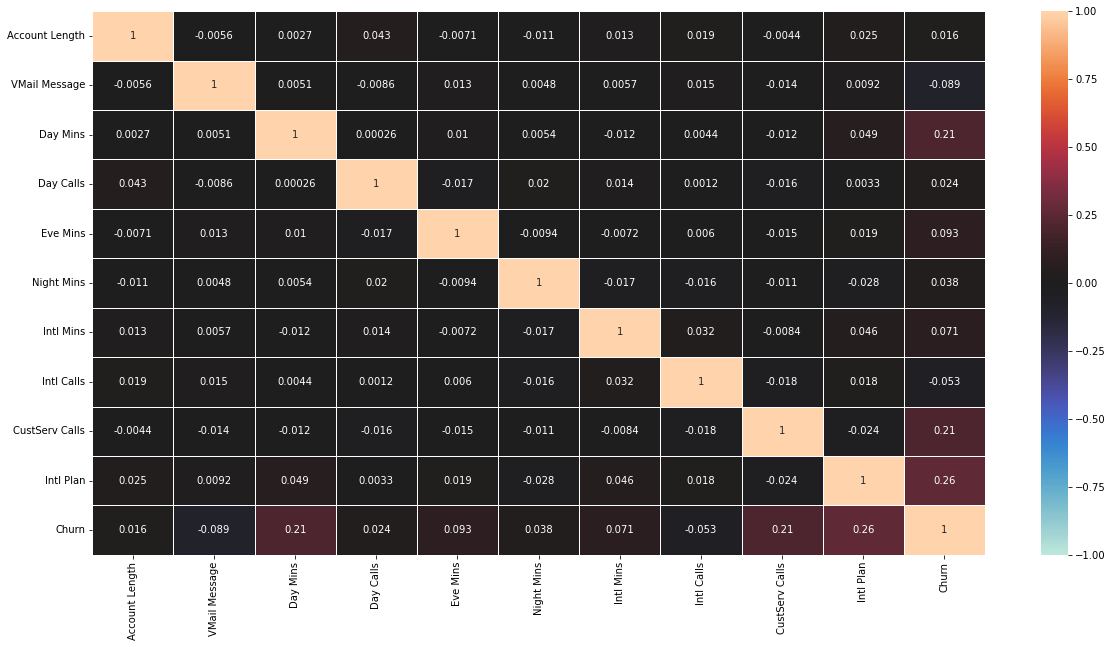

In [16]:
g = sns.heatmap(df_clean.corr(),annot=True,vmin=-1, vmax=1, center= 0, yticklabels=1, linewidths=.5)
g.figure.set_size_inches(20,10)

## Training Artificial Neural Network

###  feed-forward multilayer perceptron (with sigmoid activations and MSE loss function) to perform multi-class classification to classify 'Churn' based on other variables 

Using Adam optimizer because it would perform better on this model, but we can test others too.\
Adam is loosely derived from SGD and the key differences between SGD and Adam are that it includes a "momentum" term, which tends to increase the rate of convergence and avoid saddle points, and that it iteration-averages the gradient to accommodate high variance in batch-to-batch gradients.

In [17]:
#splitting dataset
train, test = train_test_split(df_clean, train_size=0.7, random_state= 0 )
model = keras.Sequential(
    [
        keras.Input(shape=(len(train.loc[:,train.columns != 'Churn'].columns))),
        layers.Dense(10, activation ='sigmoid', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 0 )),
        layers.Dense(10, activation ='sigmoid', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 0 )),
        layers.Dense(1, activation ='sigmoid', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 0 ))
    ]
)

# using Adam as optimizer since it converges, whereas SGD does not
model.compile(optimizer='adam', loss='mse',
              metrics=["accuracy",
                       keras.metrics.Precision(name="precision",thresholds=0.5),
                       keras.metrics.Recall(name="recall",thresholds=0.5)])

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                110       
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 1)                 11        
                                                                 
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [18]:
#Adding a callback function
class WeightLoggerCallback(keras.callbacks.Callback):
    def on_train_batch_end(self,batch,logs=None):
        
        # model weights
        # get_weights: (n_iterations, 2 (weights + bias), (n_inputs, n_layer_size) or (n_layer_size))
        temp = self.model.layers[1].get_weights()
        training_weights.append(temp)
        
        # model accuracy
        # the call to evaluate will be *very* slow, but is necessary for 2b.
        # the validation loss is only evaluated every epoch and is unavailable at end of batch
        loss, acc, prec, recall = self.model.evaluate(test.loc[:,test.columns != 'Churn'], test['Churn'], verbose=0)
        error_log.append({'batch': batch, 'training': logs['accuracy'], 'test': acc})

Now lets compare 

In [19]:
fit_args = {'epochs': 200, 'verbose':0, 'batch_size':32}
training_weights = []
error_log = []
history = model.fit(train.loc[:,train.columns != 'Churn'], train['Churn'],
                    **fit_args, callbacks= [WeightLoggerCallback()], 
                    validation_data = (test.loc[:,test.columns != 'Churn'], test['Churn']))
{x:history.history[x][-1] for x in history.history.keys() if x in ['precision', 'recall', 'val_precision', 'val_recall']}
# The returned history object holds a record of the loss values and metric values during training:

{'precision': 0.6052631735801697,
 'recall': 0.29870128631591797,
 'val_precision': 0.6000000238418579,
 'val_recall': 0.29801324009895325}

We can evaluate our model on the training and test sets to see what metrics we can achieve

In [20]:
# training set
model.evaluate(train.loc[:,train.columns != 'Churn'], train['Churn']);

73/73 [==============================] - 0s 656us/step - loss: 0.0966 - accuracy: 0.8678 - precision: 0.5950 - recall: 0.2182  


In [21]:
# testing set
model.evaluate(test.loc[:,test.columns != 'Churn'], test['Churn']);

32/32 [==============================] - 0s 704us/step - loss: 0.0994 - accuracy: 0.8635 - precision: 0.6000 - recall: 0.2980


We can use the standalone mode from keras to predict the training/testing data and look at the precision and recall 

In [22]:
training_predictions = model.predict(train.loc[:,train.columns != 'Churn'])
test_predictions = model.predict(test.loc[:,test.columns != 'Churn'])
m_precision = tf.keras.metrics.Precision(thresholds=0.5)
m_precision.update_state(train['Churn'],training_predictions)
print(f"Training Precision: {m_precision.result().numpy()}")
m_precision.reset_states()
m_precision.update_state(test['Churn'],test_predictions)
print(f"Test Precision: {m_precision.result().numpy()}")
m_recall = tf.keras.metrics.Recall(thresholds=0.5)
m_recall.update_state(train['Churn'],training_predictions)
print(f"Training Recall: {m_recall.result().numpy()}")
m_recall.reset_states()
m_recall.update_state(test['Churn'],test_predictions)
print(f"Test Recall: {m_recall.result().numpy()}")

Training Precision: 0.5950413346290588
Test Precision: 0.6000000238418579
Training Recall: 0.2181818187236786
Test Recall: 0.29801324009895325


## Checking convergence
Lets look at the weight values per iteration for the last layer &\
Training & test error per iteration

<AxesSubplot:>

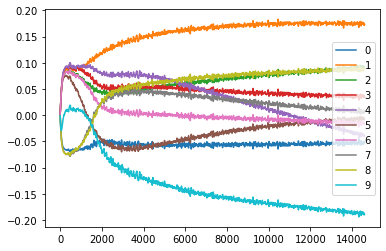

In [23]:
biases = [x[-1] for x in training_weights]

pd.DataFrame(biases).plot()

<AxesSubplot:>

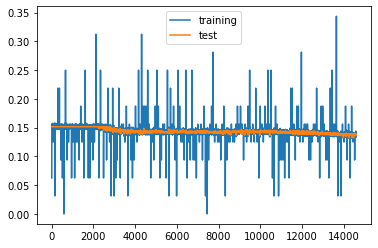

In [24]:
pd.DataFrame(error_log)[['training','test']].apply(lambda x: 1-x).plot()

### We can see that the models are nearly converged but there are still some fluctuations. This could be fixed with some hyperparameter tuning (learning rate or momentum)

Now we will re-train the whole ANN with all data , we should expect training error to go down with more data

In [25]:
# compiling with no validation split 
model.compile(optimizer='adam', loss='mse',
              metrics=["accuracy",
                       keras.metrics.Precision(name="precision",thresholds=0.5),
                       keras.metrics.Recall(name="recall",thresholds=0.5)])

training_weights = []
history = model.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args)
{x:history.history[x][-1] for x in history.history.keys() if x in ['precision', 'recall']}

{'precision': 0.8327272534370422, 'recall': 0.4760914742946625}

In [26]:
# compilation with validation split
model.compile(optimizer='adam', loss='mse',
              metrics=["accuracy",
                       keras.metrics.Precision(name="precision",thresholds=0.5),
                       keras.metrics.Recall(name="recall",thresholds=0.5)])

training_weights = []
history = model.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args, validation_split=0.8)
{x:history.history[x][-1] for x in history.history.keys() if x in ['precision', 'recall', 'val_precision', 'val_recall']}

{'precision': 0.8333333134651184,
 'recall': 0.43478259444236755,
 'val_precision': 0.8524590134620667,
 'val_recall': 0.40102827548980713}

In [ ]:
{x:history.history[x][-1] for x in history.history.keys() if x in ['accuracy']}

We can see that the model performs better with a validation split, so our model is now complete. \
# Lets try to tune hyperparameters to improve performance

In [16]:
#fix the random seed for better reproducibility
tf.random.set_seed(0)
# import the necessary packages
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

# The next 4 blocks of codes have been discontinued by Keras and replaced by scikeras, done below 

#from keras import backend as K
def get_mlp_model(hiddenLayerOne=10, hiddenLayerTwo=10, 
                  dropout=0.2, optimizer__lr=0.0001):
    # initialize a sequential model and add layer to flatten the
    # input data
    #K.set_value(model.optimizer.learning_rate, learnRate)
    model = Sequential() 
    model.add(Flatten())
    # add two stacks of FC => RELU => DROPOUT
    model.add(Dense(hiddenLayerOne, activation="sigmoid", kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42),
        input_shape=(len(train.loc[:,train.columns != 'Churn'].columns))))
    model.add(Dropout(dropout))
    model.add(Dense(hiddenLayerTwo, activation="sigmoid"),kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
    model.add(Dropout(dropout))
    # add a softmax layer on top
    model.add(Dense(1, activation="sigmoid"),kernel_initializer=tf.keras.initializers.GlorotUniform(seed=42))
    # compile the model
    model.compile(
        optimizer=Adam(learning_rate=learnRate),
        loss="mse",
        metrics=["accuracy",
                keras.metrics.Precision(name="precision",thresholds=0.5),
                keras.metrics.Recall(name="recall",thresholds=0.5)])
    # return compiled model
    return model

model = KerasClassifier(build_fn=get_mlp_model, verbose=0)
# define a grid of the hyperparameter search space
hiddenLayerOne = [5, 10, 15, 20 ]
hiddenLayerTwo = [5, 10, 15, 20 ]
optimizer__lr = [1e-3, 1e-4, 1e-5]
dropout = [0.3, 0.4, 0.5]
batchSize = [4, 8, 16, 32]
epochs = [10, 20, 30, 40]
# create a dictionary from the hyperparameter grid
grid = dict(
	hiddenLayerOne=hiddenLayerOne,
	optimizer__lr=optimizer__lr,
	hiddenLayerTwo=hiddenLayerTwo,
	dropout=dropout,
	batch_size=batchSize,
	epochs=epochs
)

#initialize search
searcher = RandomizedSearchCV(estimator=model, n_jobs=-1, cv=3,
	param_distributions=grid, scoring="accuracy")
searchResults = searcher.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args)
# summarize grid search information
bestScore = searchResults.best_score_
bestParams = searchResults.best_params_
print("[INFO] best score is {:.2f} using {}".format(bestScore,
	bestParams))


#Lets see what the best model was!
bestModel = searchResults.best_estimator_
accuracy = bestModel.score(testData, testLabels)
print("accuracy: {:.2f}%".format(accuracy * 100))

# New SciKeras method

In [18]:
def get_clf(meta, hidden_layer_sizes, dropout):
    n_features_in_ = meta["n_features_in_"]
    n_classes_ = meta["n_classes_"]
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=(n_features_in_,)))
    for hidden_layer_size in hidden_layer_sizes:
        model.add(keras.layers.Dense(hidden_layer_size, activation="sigmoid"))
        model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(1, activation="sigmoid"))
    return model

In [32]:
from sklearn.model_selection import GridSearchCV

clf = KerasClassifier(
        model=get_clf,
        loss="mse",
        optimizer="adam",
        optimizer__lr=0.1,
        hidden_layer_sizes=(10,),
        dropout=0.5,
        verbose=False
)

params = {
    'optimizer__lr': [0.01, 0.001,0.0001,0.00001 ],
    'model__hidden_layer_sizes': [(10,10, ), (15, 15, ), (15, 10, ), (20, 20, )],
    'model__dropout': [0.3, 0.4, 0.5],
    'model__batch__size' : [4, 8, 16, 32]
}

gs = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, verbose=True)

gs.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args)

print(gs.best_score_, gs.best_params_)


Fitting 5 folds for each of 192 candidates, totalling 960 fits


C:\JupyterLab\resources\jlab_server\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0.9273655708808082 {'model__batch__size': 8, 'model__dropout': 0.3, 'model__hidden_layer_sizes': (20, 20), 'optimizer__lr': 0.01}


# Testing other hyperparameters to see if model needs bigger hidden layers

In [21]:
from sklearn.model_selection import GridSearchCV

clf = KerasClassifier(
        model=get_clf,
        loss="mse",
        optimizer="adam",
        optimizer__lr=0.1,
        hidden_layer_sizes=(10,),
        dropout=0.5,
        verbose=False
)

params = {
    'optimizer__lr': [0.01],
    'model__hidden_layer_sizes': [(30,30, ), (40, 40, ), (50, 50, ), (20, 20, )],
    'model__dropout': [0.3]
}

gs = GridSearchCV(clf, params, scoring='accuracy', n_jobs=-1, verbose=True)

fit_args = {'epochs': 200, 'verbose':0, 'batch_size':8}

gs.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args)

print(gs.best_score_, gs.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\JupyterLab\resources\jlab_server\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


0.9394228497701211 {'model__dropout': 0.3, 'model__hidden_layer_sizes': (50, 50), 'optimizer__lr': 0.01}


## It can probably be tuned even more, but since my computer isn't strong enough, I will leave it here

# Recompiling Model with new params


In [16]:

model2 = keras.Sequential(
    [
        keras.Input(shape=(len(df_clean.loc[:,df_clean.columns != 'Churn'].columns))),
        layers.Dense(50, activation ='sigmoid', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 0 )),
        layers.Dropout(0.3),
        layers.Dense(50, activation ='sigmoid', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 0 )),
        layers.Dropout(0.3),
        layers.Dense(1, activation ='sigmoid', kernel_initializer = tf.keras.initializers.GlorotUniform(seed = 0 ))
    ]
)
tf.keras.optimizers.Adam(learning_rate=0.01)
# using Adam as optimizer since it converges, whereas SGD does not
model2.compile(optimizer='adam', loss='mse',
              metrics=["accuracy",
                       keras.metrics.Precision(name="precision",thresholds=0.5),
                       keras.metrics.Recall(name="recall",thresholds=0.5)])
# compilation with validation split
training_weights = []
fit_args = {'epochs': 200, 'verbose':0, 'batch_size':8}
history = model2.fit(df_clean.loc[:,df_clean.columns != 'Churn'], df_clean['Churn'], **fit_args, validation_split=0.8)
{x:history.history[x][-1] for x in history.history.keys() if x in ['precision', 'recall', 'val_precision', 'val_recall']}


{'precision': 0.6000000238418579,
 'recall': 0.06521739065647125,
 'val_precision': 0.695652186870575,
 'val_recall': 0.04113110527396202}

In [17]:
{x:history.history[x][-1] for x in history.history.keys() if x in ['accuracy']}


{'accuracy': 0.8642534017562866}

## Should have scored the gridsearch in precision and recall instead of accuracy but now we have high accuracy! lol